### Libraries importation and GPU setting

In [1]:
from tensorflow.keras.applications import DenseNet121
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.inputs.keras import PlotLossesCallback

Using TensorFlow backend.


In [2]:
#Enable GPU utilization
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

### Define some parameters

In [3]:
batch_size = 32
img_rows, img_cols = 224, 224 
num_classes = 10
epochs = 10

### Let's build and compile our model

In [4]:
def build_model(input_shape, num_classes,optim):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    
    model_base = DenseNet121(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape)
    
    for layer in model_base.layers:
        layer.trainable = False

    x = model_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512,activation='relu')(x)
    x_output = Dense(num_classes,activation='softmax')(x)
    
    model =  Model(inputs = model_base.input, outputs = x_output)
    
    print(model.summary())
    
    model.compile(loss = 'categorical_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
    
    return model

input_shape = (img_rows, img_cols, 3)
optimizer = RMSprop(lr = 0.001)

final_model = build_model(input_shape, num_classes, optimizer)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### Loading our Monkey Breed Dataset

In [5]:

def data_augmentation(train_data_dir,validation_data_dir):

    # Let's use some data augmentaiton 
    train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=45,
          width_shift_range=0.3,
          height_shift_range=0.3,
          horizontal_flip=True,
          fill_mode='nearest')

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')

    validation_generator = validation_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical')
    
    return train_generator, validation_generator

train_data_dir = './monkey_breed/train'
validation_data_dir = './monkey_breed/validation'

training_data,validation_data = data_augmentation(train_data_dir, validation_data_dir)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Training out Model
- Note we're using checkpointing and early stopping

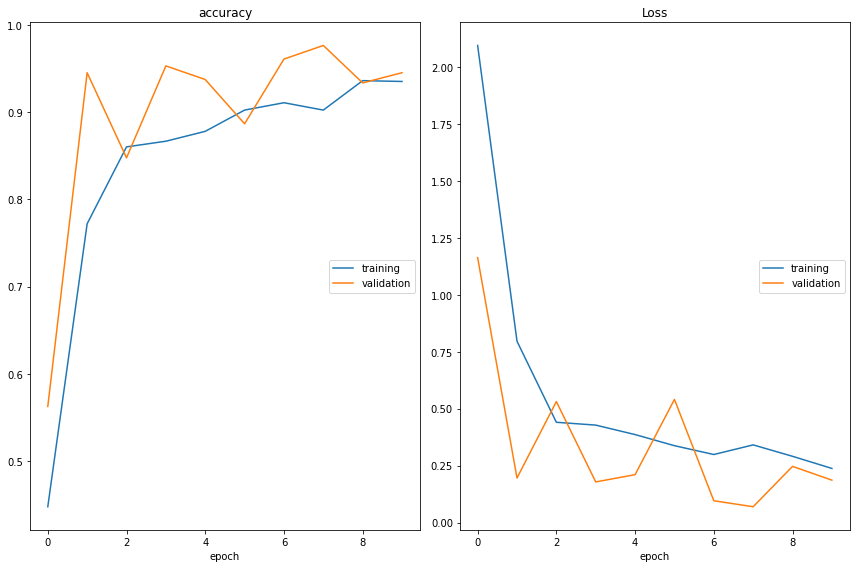

accuracy
	training         	 (min:    0.447, max:    0.936, cur:    0.935)
	validation       	 (min:    0.562, max:    0.977, cur:    0.945)
Loss
	training         	 (min:    0.238, max:    2.094, cur:    0.238)
	validation       	 (min:    0.070, max:    1.163, cur:    0.187)


In [10]:
# define a variable to display accuracy and loss performance and plot their graph in real-time 
plot_accuracy_loss = PlotLossesCallback()


checkpoint = ModelCheckpoint("monkey_breed_densnet121.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, plot_accuracy_loss]

# Enter the number of training and validation samples here
nb_train_samples = 1098
nb_validation_samples = 272


history = final_model.fit_generator(
    training_data,
    steps_per_epoch = nb_train_samples // 32,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_data,
    validation_steps = nb_validation_samples // 32)